/var/folders/_d/d1q14x755jz_4hlm6q_jlqj80000gn/T/ipykernel_5638/3036721289.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j * cell_size, i * cell_size), cell_size, cell_size, color='white', linewidth=1, edgecolor='black'))


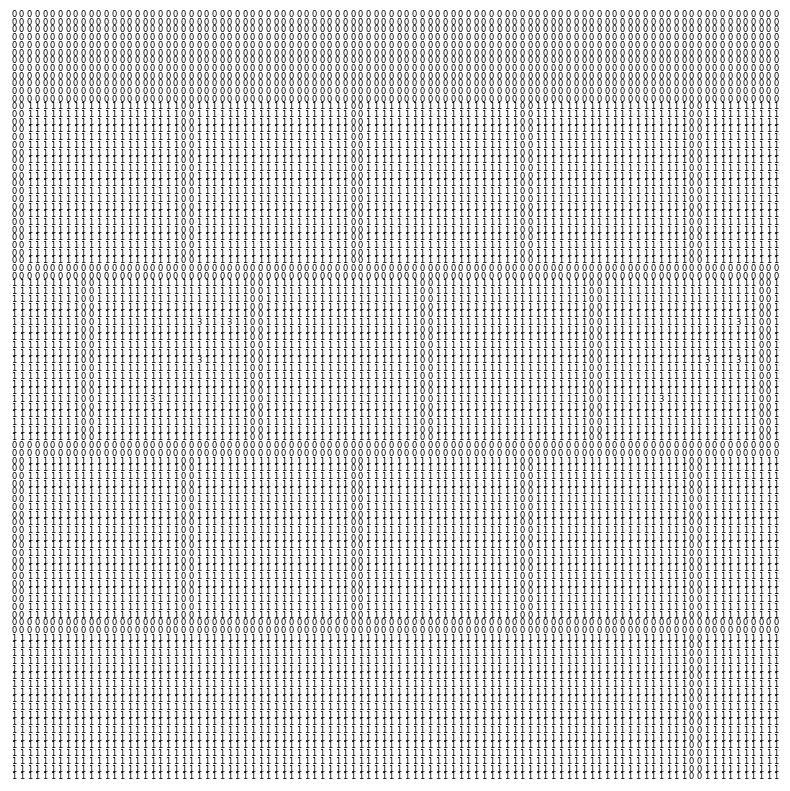

In [3]:
# ====== TOPOGRAPHY IMAGE GENERATOR ====== #

import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file into a numpy array
array = np.flipud(np.genfromtxt('Topography_Data/keyboard_topography.csv', delimiter=','))

# Define cell size
cell_size = 1

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))

# Set white background
ax.set_facecolor('white')

# Iterate over each cell and add text
for i in range(array.shape[0]):
    for j in range(array.shape[1]):
        ax.add_patch(plt.Rectangle((j * cell_size, i * cell_size), cell_size, cell_size, color='white', linewidth=1, edgecolor='black'))
        ax.text(j * cell_size + cell_size / 2, i * cell_size + cell_size / 2, str(int(array[i, j])), ha='center', va='center', color='black', fontsize=6)

# Set limits and aspect ratio
ax.set_xlim(0, array.shape[1] * cell_size)
ax.set_ylim(0, array.shape[0] * cell_size)
ax.set_aspect('equal')

# Hide axes
ax.axis('off')

# Save the image
plt.savefig('array_image.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show plot
plt.show()



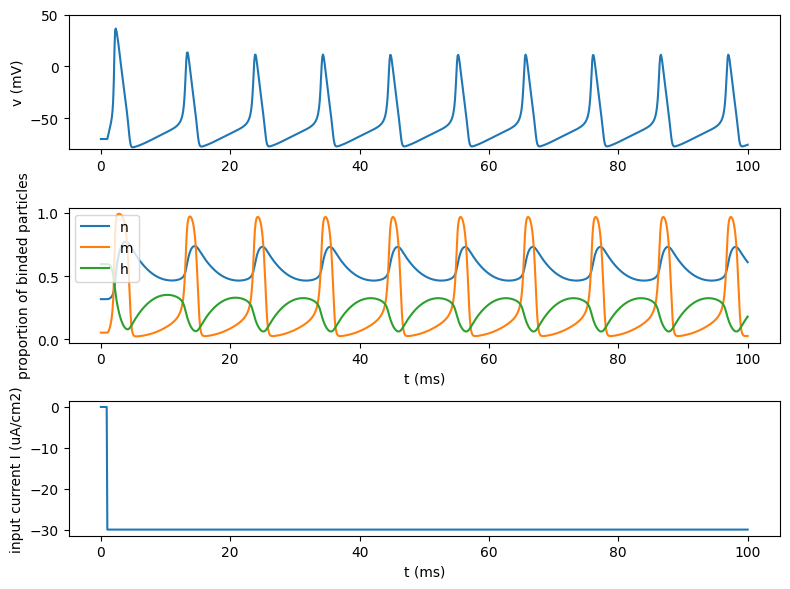

In [59]:
# ====== HODGKIN HUXLEY MODEL ====== #
# - Static model where the membrane potential is updated based on the input current

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the function to calculate the derivatives
def x_dot(x, t):
    v, n, m, h = x

    # input function
    I = input_func(t)

    # Constants from Hodgkin and Huxley
    Cm = 1
    vna = -115
    vk = 12
    vl = -10.613
    gna = 120
    gk = 36
    gl = 0.3

    v_dot = 1/Cm * (I + gk * n**4 * (vk - v) + gna * m**3 * h * (vna - v) + gl * (vl - v))
    n_dot = alpha_n(v) * (1 - n) - beta_n(v) * n
    m_dot = alpha_m(v) * (1 - m) - beta_m(v) * m
    h_dot = alpha_h(v) * (1 - h) - beta_h(v) * h

    return [v_dot, n_dot, m_dot, h_dot]

# Define the input function
def input_func(t):
    if 1 < t:  # and t < 1.4:
        I = -30
    else:
        I = 0
    return I

# Define the alpha and beta functions
def alpha_n(v):
    return 0.01 * (v + 10) / (np.exp((v + 10)/10) - 1)

def beta_n(v):
    return 0.125 * np.exp(v/80)

def alpha_m(v):
    return 0.1 * (v + 25) / (np.exp((v + 25)/10) - 1)

def beta_m(v):
    return 4 * np.exp(v/20)

def alpha_h(v):
    return 0.07 * np.exp(v/20)

def beta_h(v):
    return 1/(np.exp((v + 30)/10) + 1)

# Define initial conditions and time span
x0 = [0, 0.3177, 0.0529, 0.595]
tspan = np.linspace(0, 100, 1000)

# Solve the ODEs
sol = odeint(x_dot, x0, tspan)
v, n, m, h = sol.T

# Calculate modern_v
modern_v = -v - 70

# Plotting
plt.figure(figsize=(8, 6))

plt.subplot(3, 1, 1)
plt.plot(tspan, modern_v)
plt.ylabel('v (mV)')
plt.ylim([-80, 50])

plt.subplot(3, 1, 2)
plt.plot(tspan, n, label='n')
plt.plot(tspan, m, label='m')
plt.plot(tspan, h, label='h')
plt.ylabel('proportion of binded particles')
plt.xlabel('t (ms)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(tspan, [input_func(t) for t in tspan])
plt.xlabel('t (ms)')
plt.ylabel('input current I (uA/cm2)')

plt.tight_layout()
plt.show()


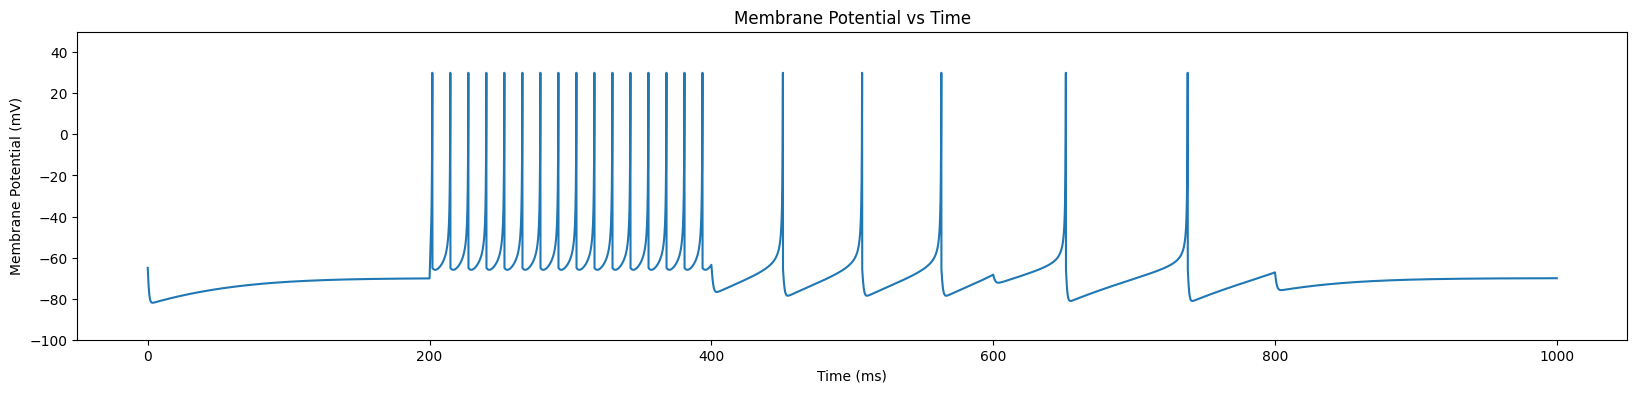

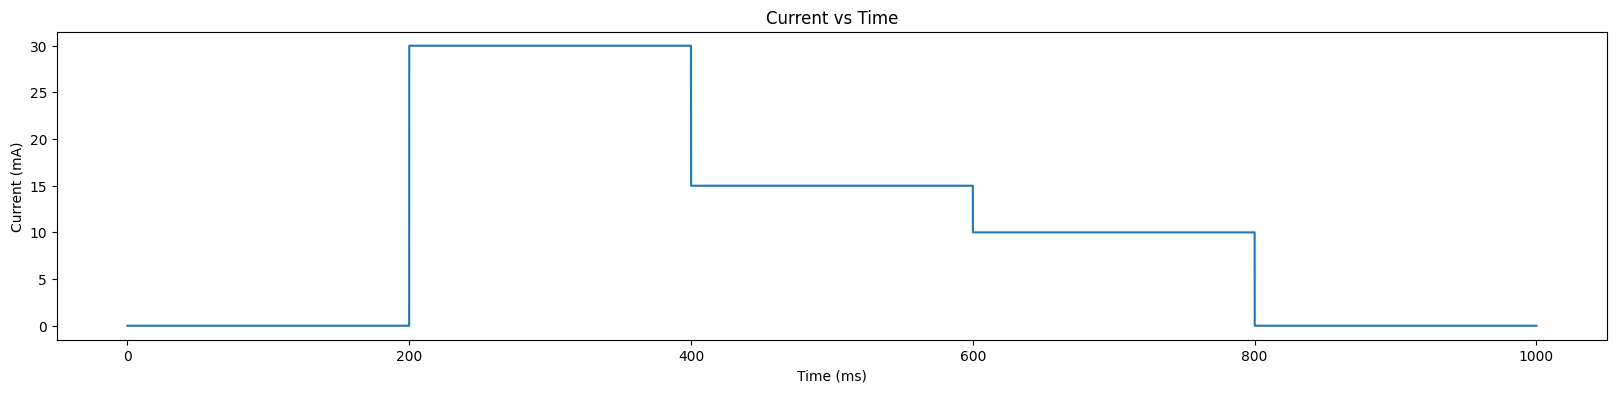

In [72]:
# ====== BASIC IZH MODEL ====== #
# - Static model where the membrane potential is updated based on the input current

import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt

# ====== MODEL PARAMETERS ====== #
#   - a, b, c, and d are neuron parameters (Izhikevich model)
#   - v_th is the threshold voltage
#   - Cm is the membrane capacitance
#   - K_x is a gain factor
#   - I is the initial current
# ============================== #
def InitializeNeuron(neuron_type, neuron_response):
    if neuron_response == 0:
        return {
            'a': 0.02,
            'b': 0.2,
            'c': -65,
            'd': 6,
            'v_th': 30,
            'Cm': 1,
            'K_one': 0.7,
            'K_two': 3,
            'neuron_type': neuron_type
        }
    else:
        return {
            'a': 0.02,
            'b': 0.2,
            'c': -50,
            'd': 1.5,
            'v_th': 30,
            'Cm': 1,
            'K_one': 0.7,
            'K_two': 3,
            'neuron_type': neuron_type
        }

# ====== MODEL EQUATIONS ====== #
#   - dv and du are the differential equations for the membrane potential and recovery variable
#   - Use Euler's method to update the state of the neuron
# ============================= #
def UpdateNeuronState(parameters, v, u, t, dt, I):
    a, b, c, d, v_th, Cm, K_one, K_two, neuron_type = parameters.values()

    for i in range(4):
        if i < 2:
            I[i * 20000:(i + 1) * 20000] = i * 30
        else:
            I[i * 20000:(i + 1) * 20000] = (i - 5) * -5

    if neuron_type == 0:
        dv = (0.04 * v[t]**2) + (5 * v[t]) + 140 - u[t] + (K_one / Cm) * I[t]
        du = a * (b * v[t] - u[t])

        if v[t] > v_th:
            v[t] = v_th
            v[t+1] = c
            u[t+1] += d
        else:
            u[t+1] = u[t] + dt * du
            v[t+1] = v[t] + dt * dv

    else:
        dv = (0.04 * v[t]**2) + (5 * v[t]) + 140 - u[t]
        du = a * (b * v[t] - u[t])

        if v[t] > v_th:
            v[t] = v_th
            v[t+1] = c
            u[t+1] += d
        else:
            u[t+1] = u[t] + dt * du
            v[t+1] = v[t] + dt * dv + (K_two / Cm) * ((np.abs(I[t + 1] - I[t])))

# ====== PLOT RESULTS ====== #
#   - Membrane Potential vs Time plots the membrane potential over 1000 ms
#   - Add plot for recovery variable
#   - Add plot for firing rate vs current
# ========================== #
def PlotNeuronResults(time, v, I):
    output_folder = "Output_Data"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    y_min = -100 # Set your desired minimum value
    y_max = 50

    plt.figure(figsize=(20, 4))
    plt.ylim(y_min, y_max)
    plt.plot(time, v)
    plt.title('Membrane Potential vs Time')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.savefig(os.path.join(output_folder, 'Basic_Model_Output.png'))
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.plot(time, I)
    plt.title('Current vs Time')
    plt.xlabel('Time (ms)')
    plt.ylabel('Current (mA)')
    plt.savefig(os.path.join(output_folder, 'Basic_Model_Current_Input.png'))
    plt.show()

# ====== SIMULATE NEURON ====== #
#   - Given the type of neuron and parameters, simulate the neuron over 1000 ms
#   - Initialize the membrane potential and recovery variable at t = 0
#   - Return the time and membrane potential
# ============================ #
def NeuronSimulate(parameters, dt, total_time, I):
    num_steps = int(total_time / dt)

    v = np.zeros(num_steps)
    u = np.zeros(num_steps)
    time = np.linspace(0, total_time, num_steps)

    v[0] = -65
    u[0] = 0

    for t in range(num_steps - 1):
        UpdateNeuronState(parameters, v, u, t, dt, I)

    return time, v

# ====== MAIN ====== #
#   - Contains all functions of the model
#   - Initialize the neuron type (Spiking = 0, Bursting = 1)
#   - Simulate the neuron
#   - Plot the results
# ================== #
def main():
    # Neuron type (SA-1 = 0, FA-1 = 1)
    neuron_type = 0
    # Neuron response (Spiking = 0, Bursting = 1)
    neuron_response = 0

    I = np.zeros(100000)
    # I = np.full(100000, 20)


    parameters = InitializeNeuron(neuron_type, neuron_response)
    dt = 0.01
    total_time = 1000
    time, v = NeuronSimulate(parameters, dt, total_time, I)
    PlotNeuronResults(time, v, I)

if __name__ == "__main__":
    main()



In [1]:
# ====== STATIC MODEL ====== #
#  - This version applies the model statically over an array that simulates a surface texture
#  - Imagine a finger pressing on a surface, but no scanning movement

import numpy as np
import os
import matplotlib.pyplot as plt

# ====== MODEL PARAMETERS ====== #
#   - a, b, c, and d are neuron parameters (Izhikevich model)
#   - v_th is the threshold voltage
#   - Cm is the membrane capacitance
#   - K_x is a gain factor
#   - I is the initial current
# ============================== #
def InitializeNeuron(neuron_type, neuron_response):
    if neuron_response == 0:
        return {
            'a': 0.025,
            'b': 0.2,
            'c': -65,
            'd': 6,
            'v_th': 0.03,
            'Cm': 1,
            'K_one': 0.7,
            'K_two': 3,
            'neuron_type': neuron_type
        }
    else:
        return {
            'a': 0.02,
            'b': 0.25,
            'c': -50,
            'd': 1.5,
            'v_th': 0.03,
            'Cm': 1,
            'K_one': 0.7,
            'K_two': 3,
            'neuron_type': neuron_type
        }

# ====== MODEL EQUATIONS ====== #
#   - dv and du are the differential equations for the membrane potential and recovery variable
#   - Use Euler's method to update the state of the neuron
# ============================= #
def UpdateNeuronState(parameters, v, u, t, dt, I, spike_count):
    a, b, c, d, v_th, Cm, K_one, K_two, neuron_type = parameters.values()

    if neuron_type == 0:
        if(I[t] == 0):
            spike_count = 0

        else:
            dv = (0.04 * v[t]**2) + (5 * v[t]) + 140 - u[t] + (K_one / Cm) * I[t]
            du = a * (b * v[t] - u[t])

            if v[t] > v_th:
                v[t] = c
                u[t] += d
                spike_count += 1

            u[t+1] = u[t] + dt * du
            v[t+1] = v[t] + dt * dv

    else:
        dv = (0.04 * v[t]**2) + (5 * v[t]) + 140 - u[t]
        du = a * (b * v[t] - u[t])

        if v[t] > v_th:
            v[t] = c
            u[t] += d
            spike_count += 1


        u[t+1] = u[t] + dt * du
        v[t+1] = v[t] + dt * dv + (K_two / Cm) * (I[t + 1] - I[t])

    return spike_count

# ====== PLOT RESULTS ====== #
#   - Membrane Potential vs Time plots the membrane potential over 1000 ms
#   - Add plot for recovery variable
#   - Add plot for firing rate vs current
# ========================== #
def PlotNeuronResults(time, v, I):
    output_folder = "Output_Data"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    plt.figure(figsize=(14, 4))
    plt.plot(time, v)
    plt.title('Membrane Potential vs Time')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.savefig(os.path.join(output_folder, 'Basic_Model_Output.png'))
    plt.show()

    plt.figure(figsize=(14, 4))
    plt.plot(time, I)
    plt.title('Current vs Time')
    plt.xlabel('Time (ms)')
    plt.ylabel('Current (nA)')
    plt.savefig(os.path.join(output_folder, 'Basic_Model_Current_Input.png'))
    plt.show()


# ====== SIMULATE NEURON ====== #
#   - Given the type of neuron and parameters, simulate the neuron over 1000 ms
#   - Initialize the membrane potential and recovery variable at t = 0
#   - Return the time and membrane potential
# ============================ #
def NeuronSimulate(parameters, dt, total_time, I):
    num_steps = int(total_time / dt)

    v = np.zeros(num_steps)
    u = np.zeros(num_steps)
    time = np.linspace(0, total_time, num_steps)

    v[0] = -65
    u[0] = 0

    spike_count = 0  # Counter for spikes

    for t in range(num_steps - 1):
        spike_count = UpdateNeuronState(parameters, v, u, t, dt, I, spike_count)

    return time, v, spike_count

# ====== MAIN ====== #
#   - Contains all functions of the model
#   - Initialize the neuron type (Spiking = 0, Bursting = 1)
#   - Simulate the neuron
#   - Plot the results
# ================== #
def main():
    # Neuron type (SA-1 = 0, FA-1 = 1)
    neuron_type = 0
    # Neuron response (Spiking = 0, Bursting = 1)
    neuron_response = 0

    topography_size = 100
    # topography_array = create_ring_array(topography_size)
    # topography_array = create_topography_array()
    topography_array = np.loadtxt('Topography_Data/topography_array_output_with_commas.csv', delimiter=',')

    spike_counts_array = np.zeros((topography_size, topography_size), dtype=int)

    parameters = InitializeNeuron(neuron_type, neuron_response)
    dt = 0.01
    total_time = 1000

    for i in range(topography_size):
        for j in range(topography_size):
            I = np.full(100000, topography_array[i, j])
            time, v, spike_count = NeuronSimulate(parameters, dt, total_time, I)

            # Plot or save results as needed
            spike_counts_array[i, j] = spike_count / 20

    # # Create a heatmap
    # plt.imshow(spike_counts_array, cmap='viridis', origin='lower', extent=[0, topography_size, 0, topography_size])
    # plt.colorbar(label='Number of Spikes')
    # plt.title('Neuron Response Heatmap')
    # plt.xlabel('X Axis Index')
    # plt.ylabel('Y Axis Index')
    # plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(range(topography_size), range(topography_size))
    ax.plot_surface(x, y, spike_counts_array, cmap='viridis')
    z_min = 0  # Set your desired minimum value
    z_max = 20  # Set your desired maximum value
    ax.set_zlim(z_min, z_max)

    ax.set_xlabel('X Axis Index')
    ax.set_ylabel('Y Axis Index')
    ax.set_zlabel('Number of Spikes')
    ax.set_title('Neuron Response 3D Plot')
    plt.show()

    output_folder = "Output_Data"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    plt.savefig(os.path.join(output_folder, 'Static_Model_Output.png'))


if __name__ == "__main__":
    main()

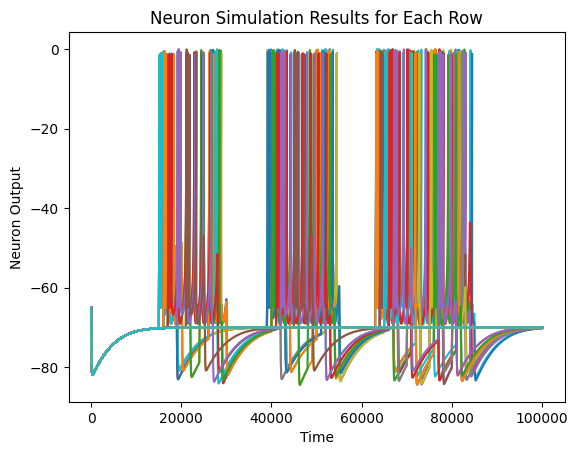

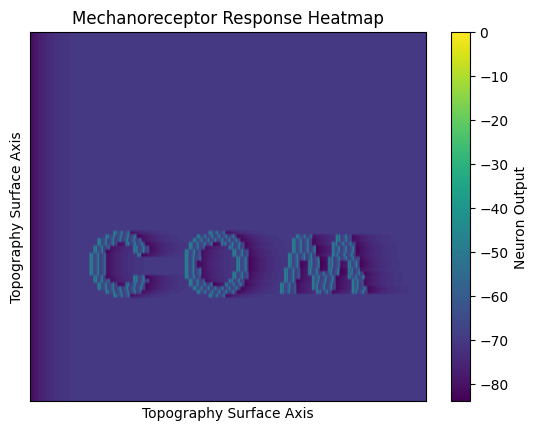

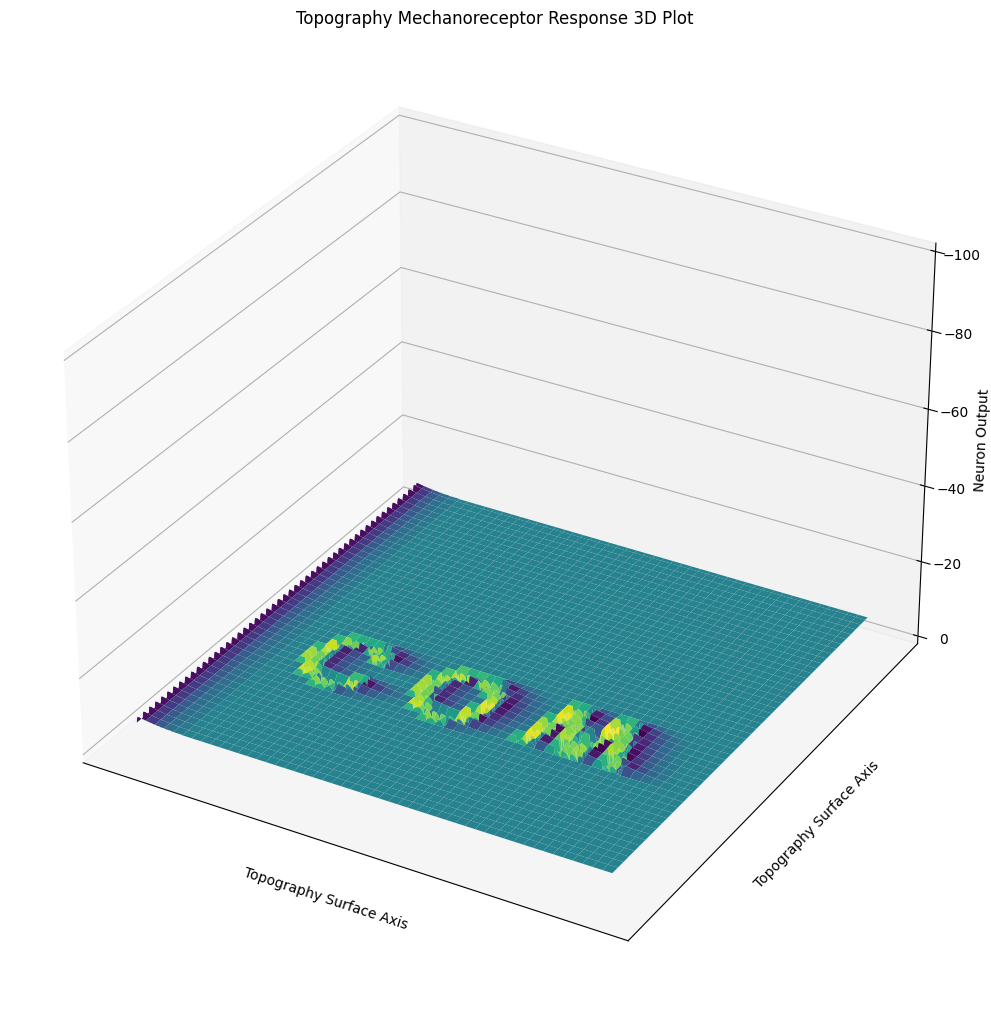

In [1]:
# ====== SCANNING MODEL ====== #
#  - This version applies the model as a strip of sensors, scanning over a surface texture

import numpy as np
import matplotlib.pyplot as plt
import os

# ====== MODEL PARAMETERS ====== #
#   - a, b, c, and d are neuron parameters (Izhikevich model)
#   - v_th is the threshold voltage
#   - Cm is the membrane capacitance
#   - K_x is a gain factor
#   - I is the initial current
# ============================== #
def InitializeNeuron(neuron_type, neuron_response):
    if neuron_response == 0:
        return {
            'a': 0.025,
            'b': 0.2,
            'c': -65,
            'd': 6,
            'v_th': 0.03,
            'Cm': 1,
            'K_one': 0.7,
            'K_two': 3,
            'neuron_type': neuron_type
        }
    else:
        return {
            'a': 0.02,
            'b': 0.25,
            'c': -50,
            'd': 1.5,
            'v_th': 0.03,
            'Cm': 1,
            'K_one': 0.7,
            'K_two': 3,
            'neuron_type': neuron_type
        }

# ====== MODEL EQUATIONS ====== #
#   - dv and du are the differential equations for the membrane potential and recovery variable
#   - Use Euler's method to update the state of the neuron
# ============================= #
def UpdateNeuronState(parameters, v, u, t, dt, I):
    a, b, c, d, v_th, Cm, K_one, K_two, neuron_type = parameters.values()

    if neuron_type == 0:
        dv = (0.04 * v[t]**2) + (5 * v[t]) + 140 - u[t] + (K_one / Cm) * I[t]
        du = a * (b * v[t] - u[t])

        if v[t] > v_th:
            v[t] = c
            u[t] += d

        u[t+1] = u[t] + dt * du
        v[t+1] = v[t] + dt * dv

    else:
        dv = (0.04 * v[t]**2) + (5 * v[t]) + 140 - u[t]
        du = a * (b * v[t] - u[t])

        if v[t] > v_th:
            v[t] = c
            u[t] += d

        u[t+1] = u[t] + dt * du
        v[t+1] = v[t] + dt * dv + ((K_two / Cm) * (I[t + 1] - I[t]))

# ====== PLOT RESULTS ====== #
#   - Membrane Potential vs Time plots the membrane potential over 1000 ms
#   - Add plot for recovery variable
#   - Add plot for firing rate vs current
# ========================== #
def PlotNeuronResults(v, spike_counts_array, total_time, topography_size):
    output_folder = "Output_Data"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    plt.xlabel('Time')
    plt.ylabel('Neuron Output')
    plt.title('Neuron Simulation Results for Each Row')
    plt.show()

    # ====== Create a heatmap ====== #
    plt.imshow(spike_counts_array[:, :len(v)], cmap='viridis', aspect='auto', origin='lower', extent=[0, total_time, 0, topography_size])
    plt.colorbar(label='Neuron Output')
    plt.title('Mechanoreceptor Response Heatmap')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Topography Surface Axis')
    plt.ylabel('Topography Surface Axis')
    plt.savefig(os.path.join(output_folder, 'Scanning_Model_Heatmap.png'))
    plt.show()

    # ====== Create a 3D plot of the topography encoding ====== #
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot(111, projection='3d')
    scaled_down_spike_counts_array = spike_counts_array[:, :len(v)] / 10.0
    x, y = np.meshgrid(np.linspace(0, total_time, len(v)), range(topography_size))
    ax.plot_surface(x, y, scaled_down_spike_counts_array, cmap='viridis')

    z_min = 0 # Set your desired minimum value
    z_max = -100  # Set your desired maximum value
    ax.set_zlim(z_min, z_max)

    plt.xticks([])
    plt.yticks([])
    ax.set_xlabel('Topography Surface Axis')
    ax.set_ylabel('Topography Surface Axis')
    ax.set_zlabel('Neuron Output')
    ax.set_title('Topography Mechanoreceptor Response 3D Plot')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'Scanning_Model_3D_Plot.png'))
    plt.show()

# ====== SIMULATE NEURON ====== #
#   - Given the type of neuron and parameters, simulate the neuron over 1000 ms
#   - Initialize the membrane potential and recovery variable at t = 0
#   - Return the time and membrane potential
# ============================ #
def NeuronSimulate(parameters, dt, total_time, I):
    num_steps = int(total_time / dt)

    v = np.zeros(num_steps)
    u = np.zeros(num_steps)
    time = np.linspace(0, total_time, num_steps)

    v[0] = -65
    u[0] = 0

    for t in range(num_steps - 1):
        UpdateNeuronState(parameters, v, u, t, dt, I)

    return time, v

# ====== MAIN ====== #
#   - Contains all functions of the model
#   - Initialize the neuron type (Spiking = 0, Bursting = 1)
#   - Simulate the neuron
#   - Plot the results
# ================== #
def main():
    # Neuron type (SA-1 = 0, FA-1 = 1)
    neuron_type = 0
    # Neuron response (Spiking = 0, Bursting = 1)
    neuron_response = 0

    topography_size = 100

    receptor_resolution = 100000

    topography_array = np.loadtxt('Topography_Data/topography_array_output_with_commas.csv', delimiter=',')

    spike_counts_array = np.zeros((topography_size, receptor_resolution), dtype=int)

    parameters = InitializeNeuron(neuron_type, neuron_response)
    dt = 0.01
    total_time = 1000

    for i in range(topography_size):
            selected_row = topography_array[i, :]
            I = np.repeat(selected_row, 1000)
            time, v = NeuronSimulate(parameters, dt, total_time, I)

            spike_counts_array[i, :len(v)] = v

            plt.plot(v, label=f'Row {i + 1}')

    PlotNeuronResults(v, spike_counts_array, total_time, topography_size)


if __name__ == "__main__":
    main()